In [19]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import lime
import time
from collections import Counter
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

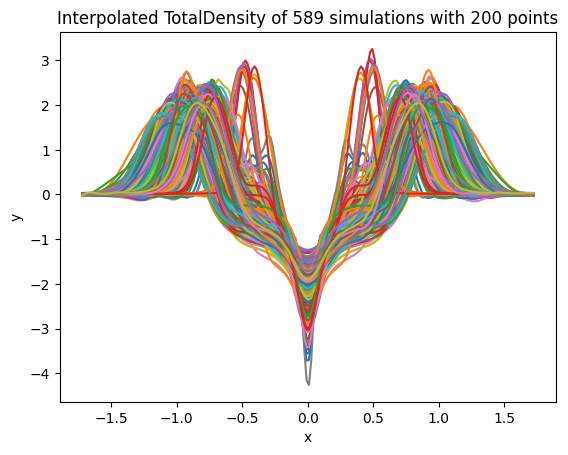

In [2]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

for i in range(0,613):
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
FF_df = (FF_df-FF_df.mean())/FF_df.std()
TD_x_df = (TD_x_df-TD_x_df.mean())/TD_x_df.std()
TD_y_df = (TD_y_df-TD_y_df.mean())/TD_y_df.std()

outlier_column_indexes = set([])

index = 0
for value in TD_y_df.iloc[99]:
    if value > -1:
        outlier_column_indexes.add(index)
    index = index + 1

index = 0 
for value in TD_y_df.iloc[5]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
index = 0 
for value in TD_y_df.iloc[15]:
    if value > 0.30:
        outlier_column_indexes.add(index)
    index = index + 1
    
FF_df = FF_df.drop(outlier_column_indexes, axis=1)
TD_x_df = TD_x_df.drop(outlier_column_indexes, axis=1)
TD_y_df = TD_y_df.drop(outlier_column_indexes, axis=1)

for i in TD_y_df.columns:
    TD_y_df[i] = TD_y_df[i]-round((TD_y_df[i][0]+TD_y_df[i][199])/2,3)
    
i = 0
for index in TD_x_df.columns:
    plt.plot(TD_x_df[index],TD_y_df[index])
    i = i + 1
    
plt.xlabel('x')
plt.ylabel('y')
plt.title('Interpolated TotalDensity of ' + str(i) + ' simulations with 200 points')
plt.show()

In [3]:
input_data = np.array(FF_df.iloc[: , :-14])
output_data_x = np.array(TD_x_df.iloc[: , :-14])
output_data_y = np.array(TD_y_df.iloc[: , :-14])
print(input_data.shape)
print(output_data_x.shape)
print(output_data_y.shape)

random.seed(42)
train = random.sample(range(0,input_data.shape[1]),int(input_data.shape[1]*0.8))
test = []
for number in range(0,input_data.shape[1]):
    if not number in train:
        test.append(number)

print(train)
print(len(train))
print(test)
print(len(test))

train_input_values = []
for number in train:
    train_input_values.append(input_data[:,number])
    
train_output_values = []
for number in train:
    train_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))

test_input_values = []
for number in test:
    test_input_values.append(input_data[:,number])
    
test_output_values = []
for number in test:
    test_output_values.append(np.concatenate((output_data_x[:,number],output_data_y[:,number])))
    
train_input_values = np.array(train_input_values).astype(np.float32)
train_output_values = np.array(train_output_values).astype(np.float32)
test_input_values = np.array(test_input_values).astype(np.float32)
test_output_values = np.array(test_output_values).astype(np.float32)

print(train_input_values.shape)
print(train_output_values.shape)
print(test_input_values.shape)
print(test_output_values.shape)

(1000, 575)
(200, 575)
(200, 575)
[114, 25, 281, 250, 228, 142, 104, 558, 89, 432, 32, 30, 95, 223, 238, 517, 27, 203, 429, 225, 459, 284, 6, 163, 565, 348, 553, 159, 220, 344, 568, 94, 389, 99, 367, 352, 270, 44, 470, 127, 387, 80, 300, 370, 196, 71, 46, 233, 296, 81, 560, 103, 542, 548, 464, 373, 166, 379, 363, 214, 273, 73, 175, 571, 83, 236, 194, 138, 506, 473, 327, 539, 285, 112, 350, 518, 431, 393, 397, 28, 117, 420, 16, 412, 161, 205, 137, 33, 108, 467, 482, 290, 448, 540, 490, 486, 335, 255, 202, 452, 468, 329, 234, 513, 135, 529, 126, 381, 287, 275, 134, 382, 299, 219, 554, 298, 204, 185, 501, 70, 260, 252, 528, 386, 24, 440, 56, 78, 321, 525, 405, 549, 216, 305, 564, 197, 195, 441, 239, 538, 128, 283, 5, 443, 369, 58, 349, 274, 384, 136, 497, 328, 174, 57, 150, 222, 533, 232, 1, 430, 368, 520, 256, 390, 91, 259, 54, 320, 152, 504, 409, 311, 101, 447, 191, 411, 82, 276, 271, 0, 306, 165, 511, 9, 421, 457, 157, 122, 29, 123, 483, 40, 43, 374, 248, 35, 272, 64, 65, 337, 243, 572

In [4]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data')
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(test_input_values)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = test_output_values[number][0:length]
        y_2 = test_output_values[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = test_output_values[index][0:length].tolist()
        t_y = test_output_values[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 10
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 80
    prediction = model.predict(test_input_values)
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))

In [5]:
train_input_values.shape

(460, 1000)

In [6]:
train_input_values[0].shape

(1000,)

In [9]:
train_output_values.shape

(460, 400)

In [7]:
train_output_values[0].shape

(400,)

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

In [32]:
xgb = xgb.XGBRegressor(n_jobs=-1, n_estimators=3000)
model = MultiOutputRegressor(estimator=xgb)

In [33]:
model.fit(train_input_values, train_output_values)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=3000, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [34]:
score = model.score(train_input_values, train_output_values)
print("Training score:", score)

Training score: 0.9895662975184939


In [35]:
ypred = model.predict(test_input_values)

In [36]:
mse = mean_squared_error(test_output_values, ypred)

rmse = np.sqrt(mse)

print('RMSE:', rmse)

RMSE: 0.2230338


In [37]:
mse

0.049744073

In [22]:
r2_score(test_output_values, ypred)

0.5491022953625341

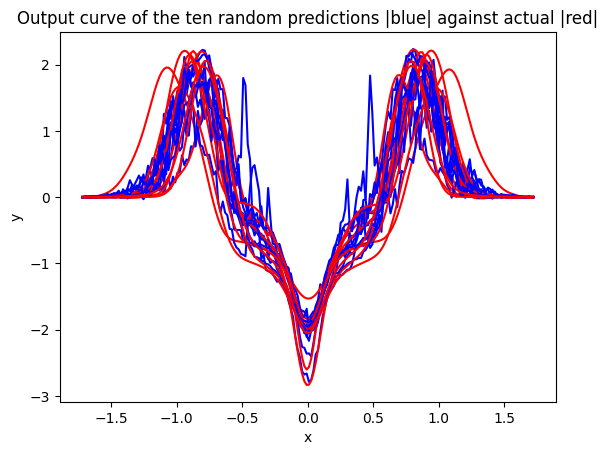

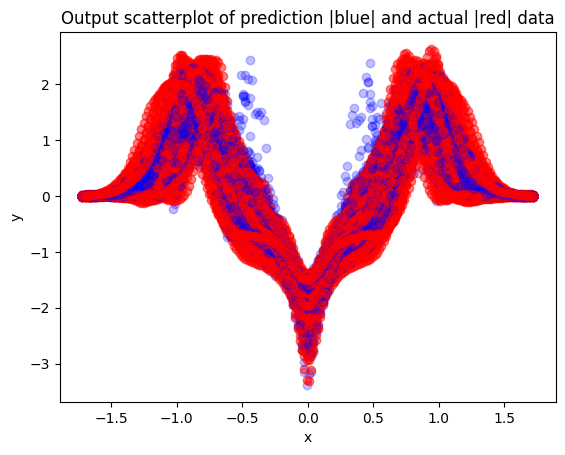

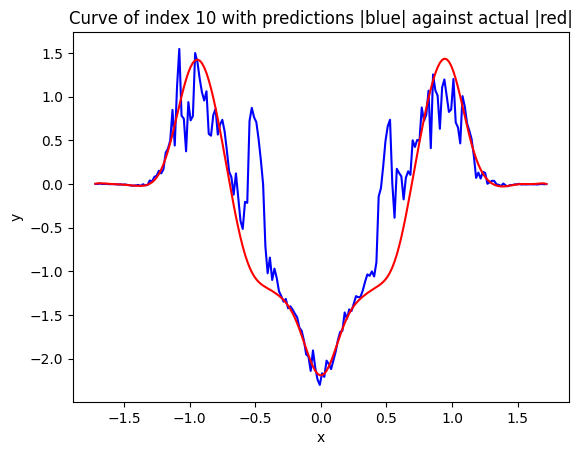

The loss of the curve 0.24680816397882033


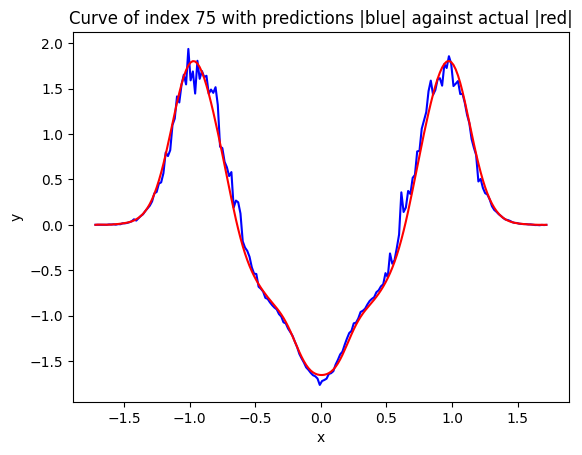

The loss of the curve 0.06008468011617074


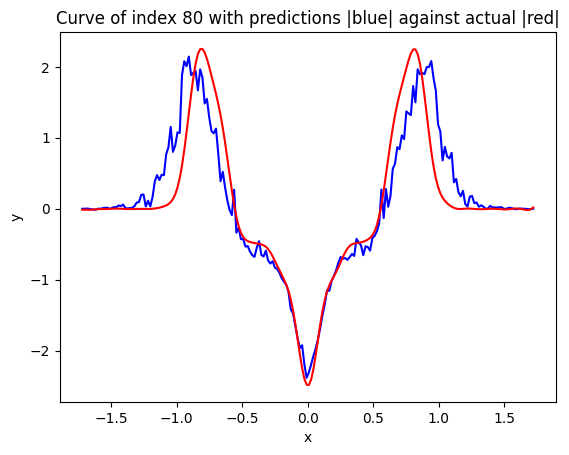

The loss of the curve 0.2637405237593533


In [23]:
plots(test_output_values, ypred)

Training score: 0.9535942813731291
